The Stacked LSTM is a model that has multiple hidden LSTM layers where each layer contains multiple memory cells. Stacking LSTM hidden layers makes the model deeper and its an important attribute of neural networks that makes them applicable to a wide range of chanllenging problem.

Stacked LSTMs or Deep LSTMs were introduced by Graves, et al. in their application of LSTMs to speech recognition, beating a benchmark on a challenging standard problem.

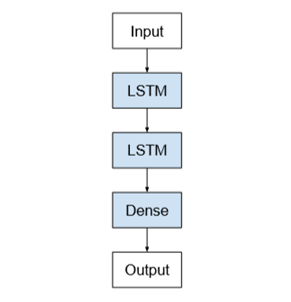

In [1]:
from IPython.display import Image
Image('C:/Users/Manoj/Desktop/Images/stacked lstm.png')

Each LSTMs memory cell requires a 3D input. When an LSTM processes one input sequence of time steps, each memory cell will output a single value for the whole sequence as a 2D array. For e.g.

In [17]:
# Example of one output for whole sequence
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# define model where LSTM is also output layer 
model = Sequential() 
model.add(LSTM(1, input_shape=(3,1))) 
model.compile(optimizer= 'adam', loss= 'mse')
# input time steps 
data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1)) 
# make and show prediction 
print(model.predict(data))

[[0.05919185]]


To stack LSTM layers, we need to change the conﬁguration of the prior LSTM layer to output a 3D array as input for the subsequent layer. We can do this by setting the **return_sequences** argument on the layer to True (defaults to False).

This will return one output for each input time step and provide a 3D array. Below is the same example as above with **return_sequences=True**.

In [4]:
# define model where LSTM is also output layer 
model = Sequential() 
model.add(LSTM(1, return_sequences = True, input_shape=(3,1))) 
model.compile(optimizer= 'adam', loss= 'mse')
# input time steps 
data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1)) 
# make and show prediction 
print(model.predict(data))

[[[-0.00275235]
  [-0.00744523]
  [-0.01336769]]]


#### Damped Sine Wave Prediction Problem

##### Sine Wave

A sine wave describes an oscillation over time that has consistent amplitude (movement from baseline) and frequency (time steps between minimum and maximum values).

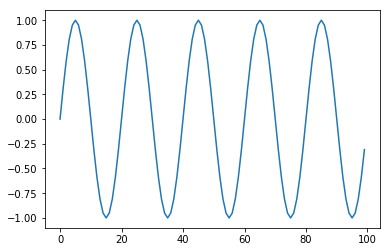

In [7]:
from math import pi, sin, exp
import matplotlib.pyplot as plt
# create sequence 
length = 100 
freq = 5 
sequence = [sin(2 * pi * freq * (i/length)) for i in range(length)]
# plot sequence 
plt.plot(sequence)

Sine wave sequence has the properties that it varies over time with upward and downward movement. This is good local movement that a Vanilla LSTM can model. A vanilla LSTM could memorize the sequence or it can use the last few time steps to predict the next time step.

##### Damped Sine Wave

Damped sine wave is a type of sine wave that decreases over time. The decrease in amplitude provides an additional longer term movement that may require an additional level of abstraction in the LSTM to learn.

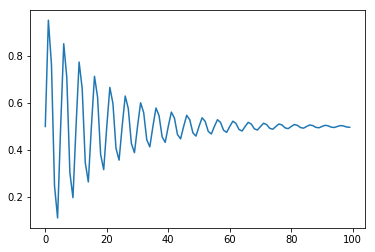

In [6]:
from math import pi, sin, exp
import matplotlib.pyplot as plt
# create sequence 
length = 100 
period = 5 
decay = 0.05 
sequence = [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]
# plot sequence 
plt.plot(sequence)

##### Sequences of Damped Sine Waves

We can generate sequences of damped sine waves with different periods and decay values, holding the last few points of the series, and have the model predict them.

Let's define a function to generate a damped sine wave called **generate_sequence()**

Next, we need a function to generate sequences with a randomly selected period and decay values.

Let's select a uniformly random periods between 10 and 20 using the randint() function and a uniformly random decay between 0.01 and 0.1 using the uniform() function.

In [10]:
from random import randint, uniform

# generate damped sine wave in [0,1] 
def generate_sequence(length, period, decay): 
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

# generate input and output pairs of damped sine waves 
def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for i in range(n_patterns):
        p = randint(10,20)
        d = uniform(0.01, 0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    X = np.array(X).reshape(n_patterns, length, 1)
    y = np.array(y).reshape(n_patterns, output)
    return X, y

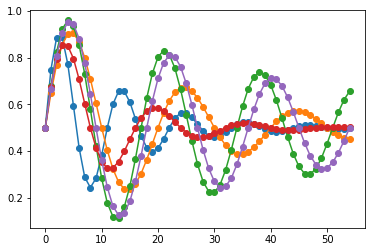

In [13]:
# test problem generation 
X, y = generate_examples(50, 5, 5)
for i in range(len(X)): 
      plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]], '-o' ) 
plt.show()

This is a regression type sequence prediction problem. It may also be considered a time series forecasting regression problem.

In time series forecasting, it is good practice to make the series stationary, that is remove any systematic trends and seasonality from the series before modeling the problem. This is recommended when working with LSTMs.

Let's not make the series stationary and see how stacked LSTM can perform on raw series.

Technically this is a many-to-one sequence prediction problem. This can be confusing as we intend to output values at multiple time steps but the catch is that model will not predict the output time steps piecewise; the whole prediction will be produced at once. Thats why it is still a many to one king of problem.

From the modeling perspective, a sequence of n time steps is fed in, then at the end of the sequence a single prediction is made; it just so happens that the prediction is a vector of n features that we will interpret as time steps.

We could adapt the model to be many-to-many with architectural changes to the proposed LSTM

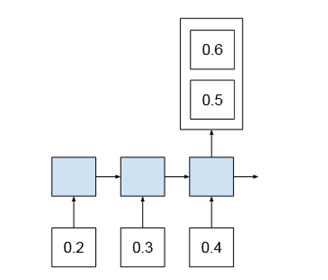

In [14]:
Image('C:/Users/Manoj/Desktop/Images/stacked lstm1.png')

#### Define and Compile Model

Let's define our model with stacking of 2 LSTM layers. Each LSTM layer will have 20 memory cells. The input dimension will be 1 feature with 20 time steps.

The output dimension of the model will be a vector of 5 values that we will interpret to be 5 time steps.

The output layer will use the linear activation function, which is the default used when no function is speciﬁed.

The Mean Absolute Error (mae) loss function will be optimized and the 'Adam' implementation of the gradient descent optimization algorithm will be used. 

In [18]:
#define model
length = 50
output = 5

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))

#compile model
model.compile(loss= 'mae', optimizer= 'adam')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 20)            1760      
_________________________________________________________________
lstm_10 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________
None


#### Fit the Model

Now ﬁt the model on a dataset of randomly generated examples of damped sine waves. The model is expected to generalize a solution to predicting the last few time steps of a damped sine wave time series.

We could generate a small number of examples and ﬁt the model on those random examples over many epochs. The downside is that model will see the same random examples many times and may try to memorize them.

Alternately, we could generate a large number of random examples and ﬁt the model on one epoch of this dataset. It would require more memory, but may offer faster training and a more generalized solution.

We will generate 10,000 random damped sine wave examples to ﬁt the model and ﬁt the model using one epoch of this dataset. This is like ﬁtting the model for 10,000 epochs. Ideally, we would reset the internal state of the model after each sample by setting the batch_size to 1.

Here we will tradeoff performance for training speed and set batch_size to 10 which means that the model weights will be updated and the LSTM memory cell internal state will be reset after each 10 samples.

In [20]:
#fit the model
X,y = generate_examples(length, 10000, output)
model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 39s 4ms/step - loss: 0.0057


We generate a new set of 1,000 random sequences and report the Mean Absolute Error (MAE)

In [21]:
# evaluate model 
X, y = generate_examples(length, 1000, output) 
loss = model.evaluate(X, y, verbose=0) 
print('MAE: %f' % loss)

MAE: 0.005248


#### Make Prediction on a new sequence

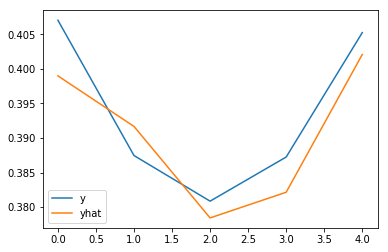

In [25]:
# prediction on new data 
X, y = generate_examples(length, 1, output) 
yhat = model.predict(X, verbose=0)
plt.plot(y[0], label= 'y') 
plt.plot(yhat[0], label= 'yhat') 
plt.legend()
plt.show()

Generating the plot shows the prediction appears to be a reasonable ﬁt for the expected sequence.

#### Conclusion

The stacked LSTM architecture is used over damped sine wave problem which is more complex than a general sine wave problem with constant amplitude and oscillations over time because of the decay factor causing dampening of amplitudes over time.

A vanilla LSTM architecture is not enough to learn this problem and need to be more deeper. 2 layers stacked LSTM architecture seems to have learned the problem better and giving a much better fit.